Importación de las bibliotecas

In [ ]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Sistema de recomendación usando una proyección de red bipartita

**Integrantes:** Isaac Cerda, David Guamán, Christian Jácome, Mateo Jaramillo, David Navarrete

## **Paso 1:** Descargar el Dataset
Ejecutar **SOLO** si **NO** se tiene la carpeta `data` en el directorio `src/app` con el archivo `ratings_electronics.csv`

In [1]:
from utils.download_dataset import download_ratings_electronics

dataset_path = download_ratings_electronics()

Descargando dataset desde KaggleHub...
Ruta del dataset descargado: C:\Users\chris\.cache\kagglehub\datasets\saurav9786\amazon-product-reviews\versions\1
Ruta del dataset: data\amazon-products-reviews\ratings_electronics.csv


## **Paso 2:** Cargar el Dataset

In [2]:
import pandas as pd

## Carga del dataset generado en la ruta del api
electronics_data = pd.read_csv(
    dataset_path, names=['userId', 'productId', 'Rating', 'timestamp']
)

## Impresión de las primeras 5 filas para validar la carga correcta del dataset
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### **Paso 2.1:** Revisar cantidad de datos del Dataset

In [4]:
electronics_data.info()
electronics_data.describe()
print(f"Total registros: {len(electronics_data):,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
Total registros: 7,824,482


## **Paso 3:** Filtrar reseñas de 5 estrellas

In [5]:
electronics_data = electronics_data[electronics_data['Rating'] == 5]
print(f"Registros luego de filtrar 5 estrellas: {len(electronics_data):,}")

Registros luego de filtrar 5 estrellas: 4,347,541


## **Paso 4:** Eliminar usuarios y productos con pocas conexiones

In [6]:
# Contar cuántos ratings tiene cada usuario y producto
user_counts = electronics_data['userId'].value_counts()
product_counts = electronics_data['productId'].value_counts()

# Mantener usuarios y productos con al menos 4 interacciones
min_user_reviews = 4
min_product_reviews = 4

filtered_users = user_counts[user_counts >= min_user_reviews].index
filtered_products = product_counts[product_counts >= min_product_reviews].index

electronics_data = electronics_data[
    electronics_data['userId'].isin(filtered_users) &
    electronics_data['productId'].isin(filtered_products)
]

print(f"Registros tras filtrado de conexiones mínimas: {len(electronics_data):,}")


Registros tras filtrado de conexiones mínimas: 1,147,489


### **Paso 4.1:** Validar campos nulos tras el filtrado

In [8]:
electronics_data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

# Grafo bipartito

Un grafo bipartito es una forma de organizar relaciones entre dos grupos distintos. En este caso se tiene dos filas: una con usuarios y otra con productos. Las conexiones, también llamadas aristas, solo pueden ir de un grupo al otro, nunca dentro del mismo grupo. Por ejemplo, un usuario puede dar 5 estrellas a un producto, pero un usuario no se conecta con otro usuario, ni un producto con otro producto.

## Artefactos:

- **Matriz de biadyacencia**: Una tabla que muestra las conexiones. Las filas son usuarios, las columnas son productos, y un "1" indica que el usuario dio 5 estrellas al producto (un "0" si no).

- **Grado de un nodo:** Cuántas conexiones tiene un nodo (por ejemplo, cuántos productos calificó un usuario, o cuántas reseñas de 5 estrellas recibió un producto).

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import random
import plotly.express as px

In [9]:
users = electronics_data['userId'].unique()
products = electronics_data['productId'].unique()

print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

Número de usuarios únicos: 184707
Número de productos únicos: 107686


In [10]:
# Debido a que el dataset es muy grande se tomon muestras
users = list(users)
products = list(products)

sample_ratio = 0.1

num_users = int(len(users) * sample_ratio)
num_products = int(len(products) * sample_ratio)

random.seed(42)
users = random.sample(users, num_users)
products = random.sample(products, num_products)

print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

Número de usuarios únicos: 18470
Número de productos únicos: 10768


In [11]:
B = nx.Graph()

# Agregar nodos al grafo
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(products, bipartite=1)

# Agregar aristas
edges = electronics_data[['userId', 'productId']].values
B.add_edges_from(edges)

is_bipartite = nx.is_bipartite(B)
print(f"¿Es el grafo bipartito? {is_bipartite}")
num_edges = B.number_of_edges()
print("Número de aristas:", num_edges)

¿Es el grafo bipartito? True
Número de aristas: 1147489


In [ ]:
# Se calcula la matriz de biadyacencia
biadj_matrix = bipartite.biadjacency_matrix(B, row_order=users, column_order=products)

biadj_matrix_dense = biadj_matrix.toarray()
print("Matriz de biadyacencia (primeras 5 filas y columnas):")
print(biadj_matrix_dense[:100, :100])

# Configurar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    biadj_matrix_dense,
    annot=True,  # Mostrar los valores en cada celda
    cmap="Blues",  # Escala de colores (azul para 0, azul intenso para 1)
    xticklabels=[f"P{i+1}" for i in range(10)],  # Etiquetas de productos
    yticklabels=[f"U{i+1}" for i in range(10)],  # Etiquetas de usuarios
    cbar_kws={'label': 'Interacción'}  # Etiqueta de la barra de color
)

# Títulos y etiquetas
plt.title("Matriz de Biadyacencia (Usuarios vs Productos)")
plt.xlabel("Productos")
plt.ylabel("Usuarios")

# Mostrar el gráfico
plt.show()

Matriz de biadyacencia (primeras 5 filas y columnas):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<Figure size 1000x800 with 0 Axes>

### Histograma de grados de usuarios

<Figure size 1000x500 with 0 Axes>

(array([1.92380e+05, 2.40189e+05, 8.12270e+04, 3.79180e+04, 2.04360e+04,
        1.27540e+04, 8.49800e+03, 6.84200e+03, 4.80700e+03, 3.08400e+03,
        2.85600e+03, 2.23600e+03, 1.07400e+03, 1.12900e+03, 1.38300e+03,
        1.30300e+03, 5.32000e+02, 6.21000e+02, 3.65000e+02, 5.54000e+02,
        3.16000e+02, 5.07000e+02, 4.52000e+02, 3.82000e+02, 1.95000e+02,
        4.15000e+02, 2.07000e+02, 4.33000e+02, 3.39000e+02, 0.00000e+00,
        2.49000e+02, 2.48000e+02, 6.48000e+02, 1.33000e+02, 0.00000e+00,
        2.86000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.62000e+02,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.73000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.93000e+02, 0.00000e+00, 1.96000e+02]),
 array([  1.  ,   5.92,  10.84,  15.76,  20.68,  25.6 ,  30.52,  35.44,
         40.36,  45.28,  50.2 ,  55.12,  60.04,  64.96,  69.88,  74.8 ,
         79.72,  84.64,  89.56,  94.48,  99.4 , 104.32, 109.24, 114.16,
        119.08, 124.  , 128.92, 133.84, 138.76, 143.

Text(0.5, 1.0, 'Distribución de grados de usuarios (reseñas dadas)')

Text(0.5, 0, 'Grado (número de reseñas de 5 estrellas)')

Text(0, 0.5, 'Frecuencia')

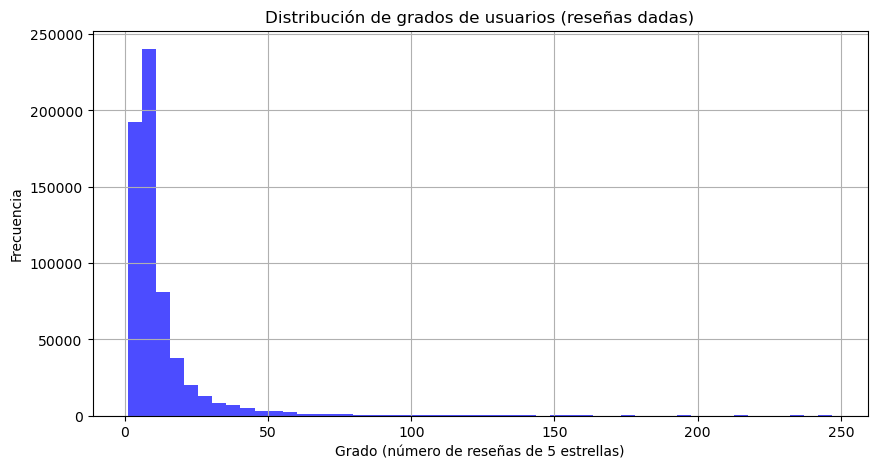

In [ ]:
# Se calculan los grados de los nodos (número de conexiones)
user_degrees = [B.degree(user) for user in users]
product_degrees = [B.degree(product) for product in products]

plt.figure(figsize=(10, 5))
plt.hist(user_degrees, bins=50, color='blue', alpha=0.7)
plt.title('Distribución de grados de usuarios (reseñas dadas)')
plt.xlabel('Grado (número de reseñas de 5 estrellas)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### Histograma de grados de productos

<Figure size 1000x500 with 0 Axes>

(array([5.6103e+04, 7.4300e+02, 1.9600e+02, 9.0000e+01, 4.4000e+01,
        2.9000e+01, 2.5000e+01, 1.7000e+01, 9.0000e+00, 7.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 6.57600e+01, 1.30520e+02, 1.95280e+02, 2.60040e+02,
        3.24800e+02, 3.89560e+02, 4.54320e+02, 5.19080e+02, 5.83840e+02,
        6.48600e+02, 7.13360e+02, 7.78120e+02, 8.42880e+02, 9.07640e+02,
        9.72400e+02, 1.03716e+03, 1.10192e+03, 1.16668e+03, 1.23144e+03,
        1.29620e+03, 1.360

Text(0.5, 1.0, 'Distribución de grados de productos (reseñas recibidas)')

Text(0.5, 0, 'Grado (número de reseñas de 5 estrellas)')

Text(0, 0.5, 'Frecuencia')

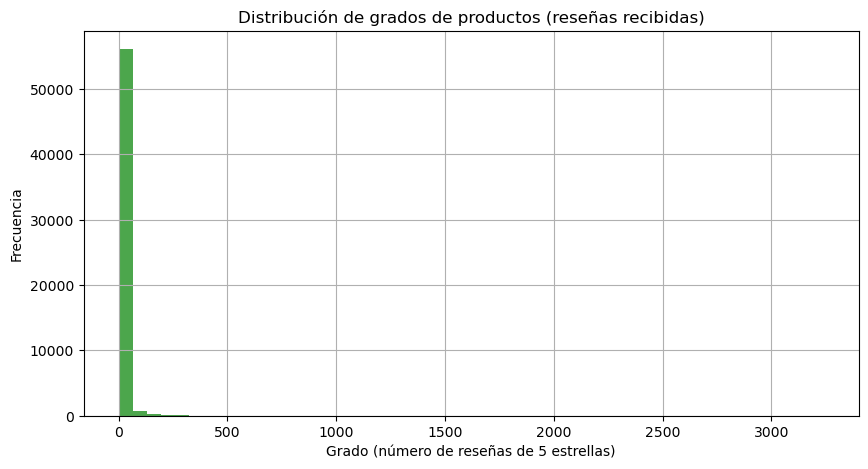

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(product_degrees, bins=50, color='green', alpha=0.7)
plt.title('Distribución de grados de productos (reseñas recibidas)')
plt.xlabel('Grado (número de reseñas de 5 estrellas)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### Resultado

In [ ]:
print(f"Número de usuarios: {len(users)}")
print(f"Número de productos: {len(products)}")
print(f"Número de aristas (reseñas de 5 estrellas): {B.number_of_edges()}")
print(f"Grado promedio de usuarios: {np.mean(user_degrees):.2f}")
print(f"Grado promedio de productos: {np.mean(product_degrees):.2f}")

Número de usuarios: 74246
Número de productos: 57286
Número de aristas (reseñas de 5 estrellas): 877820
Grado promedio de usuarios: 7.56
Grado promedio de productos: 9.91
